# Image distortion

This is a complementary file to `Example2` and the goal is develop a function that randomly distort images. We are using the same data:

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

data, metadata = tfds.load('mnist', as_supervised=True, with_info=True)

data_train, data_test = data['train'], data['test']

def normalize(images, labels):
    images = tf.cast(images, tf.float32)  # cast converts pixel values to float (they usually are in uint8 format where 0 represents black and 255 white)
    images = images / 255  # Normalize pixel values to the range [0, 1]
    return images, labels

data_train = data_train.map(normalize)
data_test = data_test.map(normalize)

# Add caching (use memory instead of disk for faster training)
data_train = data_train.cache()
data_test = data_test.cache()

# Define the classes (digits 0-9)
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

We want to **improve our test data set** in order to make the evaluation more precise. We are going to take `data_test`and we are going to apply random **affine transformations** to our images. An affine transformation is just a function which maps an affine space onto itself while preserving both the dimension of any affine subspaces and the ratios of the lengths of parallel line segments.

In [8]:
import numpy as np
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

Before make the function, we do some testing:

In [9]:
for (img, label) in data_test.take(1):
    foto = img

In [10]:
foto = foto.numpy().reshape((28,28))

In [11]:
w, h = foto.shape #there are 28 x 28

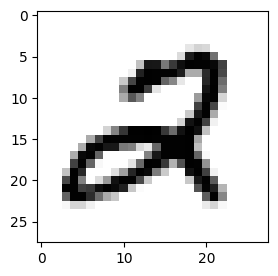

In [12]:
#Identity


mat_identity = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
img1 = ndi.affine_transform(foto, mat_identity)

plt.figure(figsize=(3,3))

plt.imshow(img1, cmap=plt.cm.binary)
plt.show()

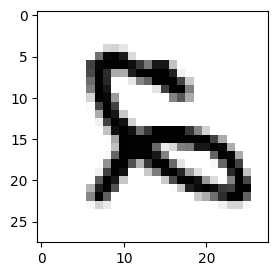

In [13]:
#Reflection

mat_reflect = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]]) @ np.array([[1, 0, 0], [0, 1, -h], [0, 0, 1]])
img2 = ndi.affine_transform(foto, mat_reflect) # offset=(0, h)

plt.figure(figsize=(3,3))
plt.imshow(img2, cmap=plt.cm.binary)
plt.show()


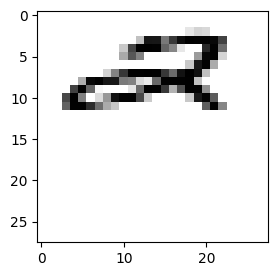

In [14]:
#Scalation

s_x, s_y = 2, 1
mat_scale = np.array([[s_x, 0, 0], [0, s_y, 0], [0, 0, 1]])
img3 = ndi.affine_transform(foto, mat_scale)

plt.figure(figsize=(3,3))
plt.imshow(img3, cmap=plt.cm.binary)
plt.show()

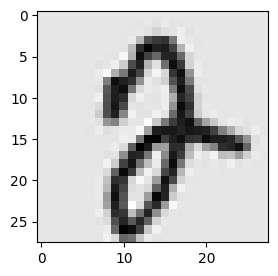

In [15]:
#Rotation

theta = np.pi / 6 # 30 degrees in radians
theta = np.random.uniform(-0.7,0.7) - np.random.uniform(-0.7,0.7)
mat_rotate = np.array([[1, 0, w/2], [0, 1, h/2], [0, 0, 1]]) @ np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]) @ np.array([[1, 0, -w/2], [0, 1, -h/2], [0, 0, 1]])
img4 = ndi.affine_transform(foto, mat_rotate)

plt.figure(figsize=(3,3))
plt.imshow(img4, cmap=plt.cm.binary)
plt.show()

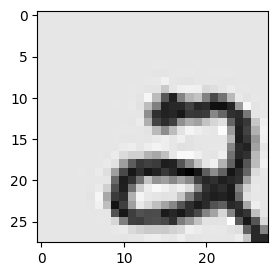

In [16]:
#Shear

lambda1 = -0.25
mat_shear = np.array([[1, lambda1, 0], [lambda1, 1, 0], [0, 0, 1]])
img5 = ndi.affine_transform(foto, mat_shear)

plt.figure(figsize=(3,3))
plt.imshow(img5, cmap=plt.cm.binary)
plt.show()

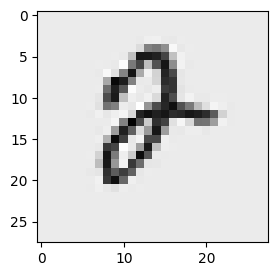

In [17]:
#All in one

mat_all = mat_identity @ mat_scale @ mat_rotate @ mat_shear
img_final = ndi.affine_transform(foto, mat_all)

plt.figure(figsize=(3,3))
plt.imshow(img_final, cmap=plt.cm.binary)
plt.show()

Let's now define the functions of scale, rotation and shear:

In [18]:
def scale(foto, s_x, s_y):
    mat_scale = np.array([[s_x, 0, 0], [0, s_y, 0], [0, 0, 1]])
    img = ndi.affine_transform(foto, mat_scale)
    return img

def rotation(foto, theta):
    w,h = foto.shape
    mat_rotate = np.array([[1, 0, w/2], [0, 1, h/2], [0, 0, 1]]) @ np.array([[np.cos(theta), np.sin(theta), 0], [-np.sin(theta), np.cos(theta), 0], [0, 0, 1]]) @ np.array([[1, 0, -w/2], [0, 1, -h/2], [0, 0, 1]])
    img = ndi.affine_transform(foto, mat_rotate)
    return img

def shear(foto, lambda1):
    mat_shear = np.array([[1, lambda1, 0], [lambda1, 1, 0], [0, 0, 1]])
    img = ndi.affine_transform(foto, mat_shear)
    return img

And now the final function, that will random all the transformations:

In [31]:
def distortion(foto): #foto is a tensorflow image
    foto = foto.numpy().reshape((28,28))
    #In the testing part before, we have seen which values are good for each parameter:
    s_x = np.random.uniform(0.8,2)
    s_y = np.random.uniform(0.8,2)
    
    theta = np.random.uniform(-0.5,0.5) * 1.5 #more high values than a uniform

    lambda1 = np.random.uniform(-0.25,0.25)

    foto1 = scale(foto, s_x, s_y)
    foto2 = rotation(foto1, theta)
    foto3 = shear(foto2, lambda1)

    
    foto3 = foto3.reshape((28, 28, 1))  #we add again the color chanel
    foto3 = np.clip(foto3, 0, 1)  # Ensure values are between 0 and 1 for proper grayscale
    
    img = tf.convert_to_tensor(foto3)
    return img


In [32]:
for (image, label) in data_train.take(4):
    fotografia = image

La size 0 es: (28, 28)


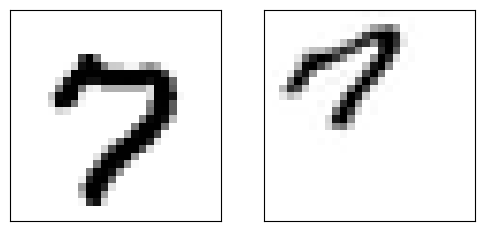

In [33]:
plt.figure(figsize=(6,3))

fotografia_numpy = fotografia.numpy().reshape((28,28))
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(fotografia_numpy, cmap=plt.cm.binary)

dist = distortion(fotografia)

dist_numpy = dist.numpy().reshape((28,28))
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(dist_numpy, cmap=plt.cm.binary)

plt.show()  